In [9]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
import time

In [ ]:
plt

In [ ]:
%config Completer.use_jedi = False

In [11]:


class Timer():
    """
    A small class to measure time during training.
    """
    def __init__(self):
        self._start_time = None

    def start(self):
        """
        Start a new timer
        """
        self._start_time = time.perf_counter()

    def stop(self):
        """
        Stop the timer, and report the elapsed time
        """
        if self._start_time is None:
            print(f"Timer is not running. Use .start() to start it")
            return 0
    
        elapsed_time = time.perf_counter() - self._start_time
        self._start_time = None
        
        return elapsed_time

In [12]:
batch_size = 32
models = ['GFDL-ESM4','IPSL-CM6A-LR','MPI-ESM1-2-HR']  # models for temp, prec, LAI
day_len = 10  # for gen_data_card()

MODEL = 'MPI-ESM1-2-HR'#np.random.choice(np.array(models))
temp_ds = np.array(xr.open_mfdataset('data/near_surface_air_temperature/historical/{}/*.nc'.format(MODEL)).tas)


prec_ds = np.array(xr.open_mfdataset('data/precipitation_flux/historical/{}/*.nc'.format(MODEL)).pr)

# Normalize inputs
temp_ds = (temp_ds - np.mean(temp_ds)) / np.std(temp_ds)
prec_ds = (prec_ds - np.mean(prec_ds)) / np.std(prec_ds)



max_month = 1978

min_month = day_len//32


def gen_data_card():
    while True:
        
        output_month_i = np.random.randint(min_month, max_month)  # y_pred timepoint in int

        # month-based metrics
        
        lai = xr.open_mfdataset('data/leaf_area_index/historical/{}/*.nc'.format(MODEL))

        # compute day index
        try:
            endstamp = lai.indexes['time'].to_datetimeindex()[output_month_i]  # cfttimeindex to datetime
        except:
            endstamp = lai.indexes['time'][output_month_i]
        output_day_i = (endstamp - pd.Timestamp('1850-01-01T12')).days  # output is i-th day in int

        # continue with month-based metrics
        lai = np.array(lai.lai)[output_month_i]
        npp_files = glob.glob('data/net_primary_production_on_land/historical/**/*.nc', recursive=True) 
        npp = xr.open_mfdataset(np.random.choice(np.array(npp_files)))
        npp = np.array(npp.npp)[output_month_i]

        # day-based metrics
        temp = temp_ds[output_day_i-day_len:output_day_i]
        prec = prec_ds[output_day_i-day_len:output_day_i]

        inputs = np.stack((temp,prec), axis=-1)  # two features
        outputs = np.stack((lai,npp), axis=-1)
        outputs = np.nan_to_num(outputs)

        yield (inputs, outputs)

In [13]:
BATCH_SIZE = 16

ds = tf.data.Dataset.from_generator(gen_data_card,output_types = (tf.float32,tf.float32))
train_ds = ds.batch(BATCH_SIZE).take(3).prefetch(tf.data.experimental.AUTOTUNE)

val_ds = ds.batch(BATCH_SIZE).take(3).prefetch(tf.data.experimental.AUTOTUNE)

In [66]:
a = []
for i in train_ds.take(1):
    print(i[0][0])

tf.Tensor(
[[[[-2.512784   -0.44727772]
   [-2.4650705  -0.44727772]
   [-2.4297342  -0.44727772]
   ...
   [-2.6296523  -0.44727772]
   [-2.5999367  -0.44727772]
   [-2.55554    -0.44727772]]

  [[-2.0333936  -0.44727772]
   [-2.1277378  -0.44727772]
   [-2.1965034  -0.44727772]
   ...
   [-1.9909233  -0.44727772]
   [-1.8987546  -0.44727772]
   [-1.7736828  -0.44727772]]

  [[-1.5059904  -0.3524496 ]
   [-1.4891313  -0.34661514]
   [-1.4943172  -0.3412043 ]
   ...
   [-1.4922099  -0.44727772]
   [-1.8012689  -0.44727772]
   [-1.6812799  -0.41342008]]

  ...

  [[-0.20360109 -0.39300036]
   [-0.20677851 -0.41138065]
   [-0.20510815 -0.39830148]
   ...
   [-0.18692897 -0.40811795]
   [-0.18678428 -0.44727772]
   [-0.19196871 -0.3960032 ]]

  [[-0.22129607 -0.38013077]
   [-0.21895383 -0.39895222]
   [-0.21698263 -0.40002558]
   ...
   [-0.22147945 -0.37127164]
   [-0.22329307 -0.36287305]
   [-0.22372855 -0.36605775]]

  [[-0.2055107  -0.384136  ]
   [-0.2066725  -0.38129818]
   [-0.20

In [14]:
class ConvLSTM(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvLSTM, self).__init__()
        
        
        self.convlstm2D_1 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same",return_sequences=True)
        
        
        self.bn_1 = tf.keras.layers.BatchNormalization()
        
        self.convlstm2D_2 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same",return_sequences=True)

        self.bn_2 = tf.keras.layers.BatchNormalization()


        self.convlstm2D_3 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same",return_sequences=True)

        self.bn_3 = tf.keras.layers.BatchNormalization()
        
        self.convlstm2D_4 = tf.keras.layers.ConvLSTM2D(filters = num_filters, kernel_size=(3,3),
                                                     padding="same",return_sequences=True)

        self.bn_4 = tf.keras.layers.BatchNormalization()
        
        self.conv3d = tf.keras.layers.Conv3D(filters = 2, kernel_size = (3,3,3), 
                                             activation= "relu", padding="same")
        
        self.bottleneck = tf.keras.layers.Conv3D(filters=1, kernel_size=1, activation="relu",strides=1)


    def call(self,x,training, shape):
        x = tf.ensure_shape(x, shape)
        x = self.convlstm2D_1(x,training= training)
        x = self.bn_1(x,training = training)
        
        x = self.convlstm2D_2(x,training = training)
        x = self.bn_2(x,training = training)
        
        x = self.convlstm2D_3(x,training = training)
        x = self.bn_3(x,training = training)
        
        x = self.convlstm2D_4(x,training = training)
        x = self.bn_4(x, training = training)
        
        x = self.conv3d(x)
        
        # bottleneck (change time_step dim to be channel dimension so we can use the bottleneck)
        x = tf.transpose(x, [0,4,2,3,1])
        x = self.bottleneck(x)
        # change back to desired dimensions
        x = tf.transpose(x, [0,4,2,3,1])
        x = tf.squeeze(x,axis=1)
        
        return x

In [53]:
@tf.function
def train_step(model, data, loss_function, optimizer, train_loss_metric, train_acc_metric, shape):
    '''
    Training for one epoch.
    '''
    for img, target in train_ds:
        # forward pass with GradientTape
        with tf.GradientTape() as tape:
            prediction = model(img, training=True, shape =  shape)
            loss = loss_function(target, prediction) + tf.reduce_sum(model.losses)

        # backward pass via GradienTape (auto-gradient calc)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # update metrics
        train_loss_metric.update_state(loss)
        train_acc_metric.update_state(target, prediction)
        
#@tf.function        
def eval_step(model, ds, loss_function, loss_metric, acc_metric, shape):
    '''
    Evaluation Loop.
    '''
    for sequence, target in ds:
        # forward pass
        prediction = model(sequence, training=False,shape = shape)
        # update metrics
        loss = loss_function(target, prediction)
        loss_metric.update_state(loss)
        acc_metric.update_state(target, prediction)
    print(target.shape,prediction.shape)
    fig, axe = plt.subplots(1,2)
    axe[0] = plt.imshow(target[5,:,0], cmap='gray', origin='lower')
    axe[1] = plt.imshow(prediction[5,:,0], cmap='gray', origin='lower')
    plt.show()

In [54]:
months = 10

#Shape: None(unspecified) batches, timesteps(in days), 72 (latitudes), 36 (longitudes), 2(temperature&precipitation)
input_shape = (16, months*30.5, 72, 36, 2)

model = ConvLSTM(num_filters=5)

model.build((16,120,72,36,2))
model.summary() # shows number of parameters

ValueError: Currently, you cannot build your model if it has positional or keyword arguments that are not inputs to the model, but are required for its `call` method. Instead, in order to instantiate and build your model, `call` your model on real tensor data with all expected call arguments.

In [55]:
import datetime

In [56]:
epochs = 100
learning_rate = 0.00001
model = ConvLSTM(num_filters = 5)
loss_function = tf.keras.losses.MAE
optimizer = tf.keras.optimizers.Adam(learning_rate)

timer = Timer()

#train_acc_metric = tf.keras.metrics.Accuracy('train_accuracy')
#val_acc_metric = tf.keras.metrics.CategoricalAccuracy('val_accuracy')

train_loss_metric = tf.keras.metrics.Mean('train_loss')
val_loss_metric = tf.keras.metrics.Mean('val_loss')

# initialize the logger for Tensorboard visualization
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'logs/gradient_tape/' + current_time + '/train_ConvLSTM'    
val_log_dir = 'logs/gradient_tape/' + current_time + '/val_ConvLSTM'       
train_summary_writer = tf.summary.create_file_writer(train_log_dir)  
val_summary_writer = tf.summary.create_file_writer(val_log_dir)


times = []

In [57]:
shape = (BATCH_SIZE, day_len, 36,72,2)


[EPOCH] ____________________0____________________
[0] - Finished Epoch in 9.57 seconds - train_loss: 1.3089, train_acc: 0.4669
(16, 36, 72, 2) (16, 36, 72, 2)


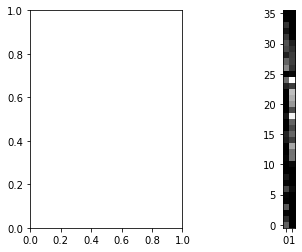


[0] - Finished evaluation - val_loss: 0.1539, val_accuracy: 0.5006

[INFO] - Total time elapsed: 0.1031 min. Total time remaining: 10.2081 min.

[EPOCH] ____________________1____________________
[1] - Finished Epoch in 6.88 seconds - train_loss: 1.3022, train_acc: 0.4676
(16, 36, 72, 2) (16, 36, 72, 2)


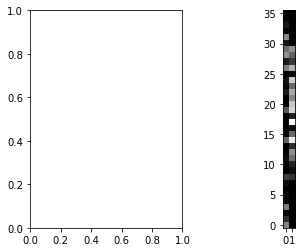


[1] - Finished evaluation - val_loss: 0.1517, val_accuracy: 0.5233

[EPOCH] ____________________2____________________
[2] - Finished Epoch in 6.83 seconds - train_loss: 1.3011, train_acc: 0.4661
(16, 36, 72, 2) (16, 36, 72, 2)


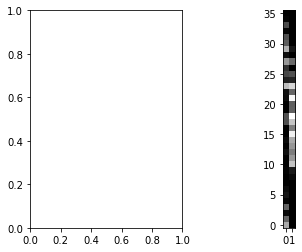


[2] - Finished evaluation - val_loss: 0.1546, val_accuracy: 0.5474

[EPOCH] ____________________3____________________
[3] - Finished Epoch in 6.97 seconds - train_loss: 1.2985, train_acc: 0.4685
(16, 36, 72, 2) (16, 36, 72, 2)


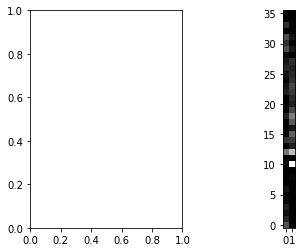


[3] - Finished evaluation - val_loss: 0.1499, val_accuracy: 0.5657

[INFO] - Total time elapsed: 0.4067 min. Total time remaining: 9.7614 min.

[EPOCH] ____________________4____________________
[4] - Finished Epoch in 7.06 seconds - train_loss: 1.2943, train_acc: 0.4671
(16, 36, 72, 2) (16, 36, 72, 2)


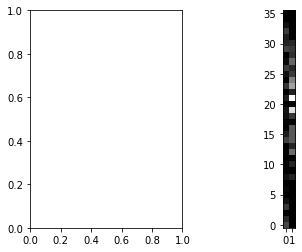


[4] - Finished evaluation - val_loss: 0.1500, val_accuracy: 0.5809

[EPOCH] ____________________5____________________
[5] - Finished Epoch in 7.04 seconds - train_loss: 1.2927, train_acc: 0.4650


KeyboardInterrupt: 

In [58]:
for epoch in range(epochs):
    print(f'\n[EPOCH] ____________________{epoch}____________________')
    
    # training step with metrics update--------------------------------------------------------
    timer.start()

    train_step(model, train_ds, loss_function, optimizer, train_loss_metric, shape)

    # Evaluating training metrics
    train_loss = train_loss_metric.result()
    #train_acc = train_acc_metric.result()
    
    with train_summary_writer.as_default():     # logging our metrics to a file which is used by tensorboard
        tf.summary.scalar('loss', train_loss, step=epoch)
        #tf.summary.scalar('accuracy', train_acc, step=epoch)

    
    elapsed_time = timer.stop()
    
    print(f'[{epoch}] - Finished Epoch in {elapsed_time:0.2f} seconds - train_loss: {train_loss:0.4f}, train_acc: {train_acc:0.4f}')
    
    # evaluation step with metrics update--------------------------------------------------------
    timer.start()

    eval_step(model, val_ds, loss_function, 
              loss_metric=val_loss_metric, 
             shape = shape)

    # Evaluating validation metrics
    val_loss = val_loss_metric.result()
    val_acc = val_acc_metric.result()
    
    with val_summary_writer.as_default():       # logging our metrics to a file which is used by tensorboard
        tf.summary.scalar('loss', val_loss, step=epoch)
        #tf.summary.scalar('accuracy', val_acc, step=epoch)
    
    print(f'\n[{epoch}] - Finished evaluation - val_loss: {val_loss:0.4f}')#, val_accuracy: {val_acc:0.4f}')
    
    # Resetting train and validation metrics-----------------------------------------------------
    #train_acc_metric.reset_states()
    #val_acc_metric.reset_states()
    train_loss_metric.reset_states()
    val_loss_metric.reset_states()
    
    elapsed_time = timer.stop()
    times.append(elapsed_time)
  
    if epoch%3 == 0:
        print(f'\n[INFO] - Total time elapsed: {np.sum(times)/60:0.4f} min. Total time remaining: {(np.sum(times)/(epoch+1))*(epochs-epoch-1)/60:0.4f} min.')

print(f'[INFO] - Total run time: {np.sum(times)/60:0.4f} min.')

In [45]:
for i,t in train_ds.take(1):
    a =model(i,training=False, shape = shape)

In [46]:
a = a.numpy()

In [64]:
np.median(a)

0.0002720684

In [56]:
t.numpy().min()

-2.1227619e-08

In [63]:
np.median(t.numpy())

0.0

In [61]:
tf.keras.backend.clear_session()